In [24]:
import config
import dataloader

import pandas as pd

In [39]:
conf = config.Config()
train_df = pd.read_csv(conf.DATA_PATH+'/train.csv')

In [40]:
d = dataloader.Dataset_for_pytorch(conf, train_df)

In [41]:
Images, Ground_Truths, Epoch_Finished = d.get_next_batch(resize=False)

['bcbc4cea8c50041454a5f7aabf77ad46' 'e0077248f5fa179c0cd638a7ddccbed4'
 '236ccdef3ad1ebc090c38ccac0fee439' 'f128bf2de1df3515ea468958fe79c2b1'
 '55f53fd1b05d44a1c5911df5a4265bfc' '8b3ef60d7abeb2067355398100653442'
 'd347fccadc4b7517f983fd965f3cd660' '935ac3caf91a29693b7cc03501b0ab98']


# Demo

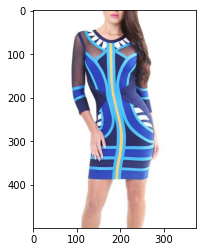

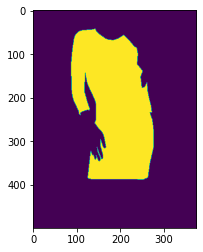

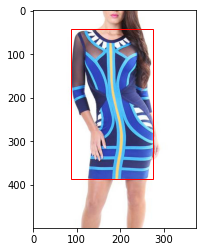

In [52]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(Images[0])
Ground_Truths[0]['masks'][3].shape
plt.figure()
plt.imshow(Ground_Truths[0]['masks'][3])
from matplotlib.patches import Rectangle
plt.figure()
plt.imshow(Images[0])
plt.gca().add_patch(Rectangle((Ground_Truths[0]['boxes'][3][0], Ground_Truths[0]['boxes'][3][1]),
                              Ground_Truths[0]['boxes'][3][2]-Ground_Truths[0]['boxes'][3][0],
                              Ground_Truths[0]['boxes'][3][3]-Ground_Truths[0]['boxes'][3][1],
                              linewidth=1,edgecolor='r',facecolor='none'))

# Model

In [44]:
import torchvision
import torch.nn as nn
import copy

In [45]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
myModel = copy.deepcopy(model)

# The model has 4 main parts
<ol>
<li>transform(GeneralizedRCNNTransform)</li> 
<li>backbone(BackbonewithFPN and FPN-FeaturePyramidNetwork)</li>
<li>rpn (RegionProposalNetwork)</li>
<li>roi_heads - RoIHeads</li>
</ol>

We need to change roi_heads as it has TwoMLPHead, FastRCNNPredictor, MaskRCNNHeads, MaskRCNNPredictor ()

In [48]:
model.roi_heads.eval()
myModel.roi_heads.box_predictor.cls_score = nn.Linear(1024, conf.NO_OF_CLASSES)
myModel.roi_heads.box_predictor.bbox_pred = nn.Linear(1024, 4*conf.NO_OF_CLASSES)
myModel.roi_heads.mask_predictor.mask_fcn_logits = nn.Conv2d(256, conf.NO_OF_CLASSES, kernel_size=(1, 1), stride=(1, 1))
myModel.roi_heads.eval()

RoIHeads(
  (box_roi_pool): MultiScaleRoIAlign()
  (box_head): TwoMLPHead(
    (fc6): Linear(in_features=12544, out_features=1024, bias=True)
    (fc7): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (box_predictor): FastRCNNPredictor(
    (cls_score): Linear(in_features=1024, out_features=46, bias=True)
    (bbox_pred): Linear(in_features=1024, out_features=184, bias=True)
  )
  (mask_roi_pool): MultiScaleRoIAlign()
  (mask_head): MaskRCNNHeads(
    (mask_fcn1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU(inplace=True)
    (mask_fcn2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU(inplace=True)
    (mask_fcn3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu3): ReLU(inplace=True)
    (mask_fcn4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu4): ReLU(inplace=True)
  )
  (mask_predictor): MaskRCNNPredictor(
    (conv5_mask): ConvTr

In [58]:
print(Images[0].shape)
print(len(Ground_Truths))
print(type(Ground_Truths[0]))
print(Ground_Truths[0]['boxes'].shape,Ground_Truths[0]['labels'].shape,Ground_Truths[0]['masks'].shape)
Epoch_Finished

(500, 375, 3)
8
<class 'dict'>
(4, 4) (4,) (4, 500, 375)


False